In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
import xgboost

In [2]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

# Engine

In [3]:
class Engine:
    def __init__(self,opset,X,Y,log_odds,p,learning_rate):
        self.generation = 0
#         self.X_train,self.X_valid,self.y_train,self.y_valid = train_test_split(X,Y,train_size=0.9)
        X = X.astype('float64')
        self.opset = opset
        
        self.num_class = len(pd.unique(Y))
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y

        self.log_odds = log_odds
        self.p = p
        self.residual = self.Y - p
        self.learning_rate = learning_rate

        self.count_label = pd.value_counts(Y).reset_index().values
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    def loss(self,vals,bins,beta):
        fitness = []
        
        for val in vals:
            val_max = np.max(val)
            val_min = np.min(val)
            width = ((val_max - val_min)/bins)

            index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
            index = np.where(index >= bins,bins-1,index)
            index = np.where(index < 0,0,index)

            p_bin = [sum(self.p[index==i]*(1-self.p[index==i]))  for i in range(bins)]
            residual_bin = [sum(self.residual[index==i])  for i in range(bins)]

            grad_bin = [residual_bin[i]/p_bin[i] if p_bin[i] > 0 else 0 for i in range(bins)]

            grads = np.zeros(index.shape[0])
            for i in range(bins):
                grads[index==i] = grad_bin[i]

            log_odds_1 = self.log_odds + self.learning_rate * grads
            p_1 = np.exp(log_odds_1)
            p_1 = p_1/(1+p_1)

            fitness.append(sum((self.Y-p_1)**2))

        return fitness
    
    def dloss(self,vals):
        return [0 for i in range(len(vals))]
    
    def evolve(self,total_size,batch_size,elite_size,bins,beta,verbose):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            # fitness = self.loss(vals,bins,beta)
            fitness = self.dloss(vals)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index] 
            )
            
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            
            if index == 0:
                if self.best[0] > node.fitness:
                    val = elite_vals[index]
                    val_max = np.max(val)
                    val_min = np.min(val)
                    width = ((val_max - val_min)/bins)
                                      
                    self.best = (node.fitness,node,(val_max,val_min,width,bins))
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.min(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

In [653]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

init_log_odds = sum(y==1)/y_train.shape[0]    
init_p = np.exp(init_log_odds)
init_p = init_p/(1+init_p)

In [659]:
df = pd.read_csv('../data/sleep.tsv',delimiter='\t')
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [669]:
from sklearn.tree import DecisionTreeClassifier

num_feature = 1500

eg = Engine(Functions.simple_opset,X_train,y_train,init_log_odds,init_p,0)
for i in range(3):
    eg.evolve(500,500,500,2,[0,0,0],0)
nodes = eg.nodes[60:60+num_feature]
# nodes = eg.nodes[0:60]

In [672]:
num_estimator = 1
max_depth = 100
ratio = 1

vals = np.stack([n.predict(X_train) for n in nodes]).T
clfs = [DecisionTreeClassifier(max_depth=max_depth) for i in range(num_estimator)]
all_index = [i for i in range(len(nodes))]
indexes = [np.random.choice(all_index,size=int(len(all_index)*ratio),replace=False) for i in range(num_estimator)]

for i in range(num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    clfs[i].fit(feature_batch,y_train)

vals = np.stack([n.predict(X_train) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_train,pred))


vals = np.stack([n.predict(X_test) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_test,pred))

/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14939
           1       1.00      1.00      1.00      6338
           2       1.00      1.00      1.00     36884
           3       1.00      1.00      1.00      7567
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00      8407

    accuracy                           0.89     74135
   macro avg       0.67      0.67      0.67     74135
weighted avg       0.89      0.89      0.89     74135

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      6420
           1       0.22      0.24      0.23      2714
           2       0.75      0.74      0.75     15814
           3       0.65      0.67      0.66      3265
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00      3560

    accuracy                           0.59     31773
   macro avg       0.38

/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhou/miniconda3/envs/tensor_gp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [631]:
from sklearn.tree import DecisionTreeClassifier

num_feature = 1000
num_estimator = 100
max_depth = 40
ratio = 0.1

eg = Engine(Functions.simple_opset,X_train,y_train,0,0,0)
for i in range(3):
    eg.evolve(1000,1000,1000,2,[0,0,0],0)
nodes = eg.nodes[60:60+num_feature]
# nodes = eg.nodes[0:60]
vals = np.stack([n.predict(X_train) for n in nodes]).T

clfs = [DecisionTreeClassifier(max_depth=max_depth) for i in range(num_estimator)]
all_index = [i for i in range(len(nodes))]
indexes = [np.random.choice(all_index,size=int(len(all_index)*ratio),replace=False) for i in range(num_estimator)]

for i in range(num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    clfs[i].fit(feature_batch,y_train)
    
vals = np.stack([n.predict(X_train) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_train,pred))


vals = np.stack([n.predict(X_test) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        63
         1.0       1.00      1.00      1.00        82

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90        34
         1.0       0.89      0.86      0.88        29

    accuracy                           0.89        63
   macro avg       0.89      0.89      0.89        63
weighted avg       0.89      0.89      0.89        63



In [531]:
from sklearn.tree import DecisionTreeClassifier

num_feature = 3000
num_estimator = 1000
max_depth = 5
ratio = 0.05

eg = Engine(Functions.simple_opset,X_train,y_train,0,0,0)
for i in range(3):
    eg.evolve(1000,1000,1000,2,[0,0,0],0)
nodes = eg.nodes[60:60+num_feature]
vals = np.stack([n.predict(X_train) for n in nodes]).T

clfs = [DecisionTreeClassifier(max_depth=max_depth) for i in range(num_estimator)]
all_index = [i for i in range(len(nodes))]
indexes = [np.random.choice(all_index,size=int(len(all_index)*ratio),replace=False) for i in range(num_estimator)]

for i in range(num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    clfs[i].fit(feature_batch,y_train)
    
vals = np.stack([n.predict(X_train) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_train,pred))


vals = np.stack([n.predict(X_test) for n in nodes]).T

feature_index = indexes[0]
feature_batch = vals[:,feature_index]
prob = clfs[0].predict_proba(feature_batch)

for i in range(1,num_estimator):
    feature_index = indexes[i]
    feature_batch = vals[:,feature_index]
    p = clfs[i].predict_proba(feature_batch)
    prob += p
    
pred = np.argmax(prob,axis=1)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        75
         1.0       1.00      1.00      1.00        70

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        22
         1.0       0.95      0.88      0.91        41

    accuracy                           0.89        63
   macro avg       0.87      0.89      0.88        63
weighted avg       0.90      0.89      0.89        63



# GStackGP

In [154]:
class GStackGP():
    def __init__(self,X,y,learning_rate):
        self.X = X
        self.y = y
        
        self.stack = []
        self.init_log_odds = sum(y==1)/y.shape[0]    
        self.init_p = np.exp(self.init_log_odds)
        self.init_p = self.init_p/(1+self.init_p)

        self.log_odds = np.array([self.init_log_odds for i in range(y.shape[0])])
        self.p = np.array([self.init_p for i in range(y.shape[0])])
        self.learning_rate = learning_rate
        
    def evolve(self):
        residual = self.y - self.p
        loss = sum(residual**2)
        if np.isnan(loss):
            print("loss is inf")
            return 
        else:
            print("Loss:",loss)
        self.E = self.trainGP(self.X,self.y,self.log_odds,self.p,self.learning_rate)
        grads,node,node_param,grad_bin = self.gradient(self.E,self.log_odds,self.p,residual)
        self.log_odds,self.p = self.update_log_p(grads,self.log_odds,self.p,self.learning_rate)
        
        self.stack.append((node,node_param,grad_bin,self.learning_rate))
        
    def trainGP(self,X,y,log_odds,p,learning_rate):
        E = Engine(Functions.simple_opset,X,y,log_odds,p,learning_rate=learning_rate)
        for i in range(30):
            E.evolve(total_size=10,batch_size=10,
                                            elite_size=3,bins=2,beta=[0,0,0],verbose=0)
        return E
    
    def gradient(self,E,log_odds,p,residual):
        node = E.best[1]
        val = E.vals[node.index]
        val_max,val_min,width,bins = E.best[2]

        index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)

        p_bin = [sum(p[index==i]*(1-p[index==i]))  for i in range(bins)]
        residual_bin = [sum(residual[index==i])  for i in range(bins)]

        grad_bin = [residual_bin[i]/p_bin[i] if p_bin[i] > 0 else 0 for i in range(bins)]

        grads = np.zeros(index.shape[0])
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        return grads,E.best[1],E.best[2],grad_bin
    
    def update_log_p(self,grads,log_odds,p,learning_rate):
        log_odds_1 = log_odds + learning_rate * grads
        p_1 = np.exp(log_odds_1)
        p_1 = p_1/(1+p_1)

        return log_odds_1,p_1
    
    def predict_prob(self,X):
        log_odds = np.array([self.init_log_odds for i in range(X.shape[0])])
        p = np.array([self.init_p for i in range(X.shape[0])])

        for param in self.stack:
            node,node_param,grad_bin,learning_rate = param
            
            val = node.predict(X)
            val_max,val_min,width,bins = node_param

            index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
            index = np.where(index >= bins,bins-1,index)
            index = np.where(index < 0,0,index)

            grads = np.zeros(index.shape[0])
            for i in range(bins):
                grads[index==i] = grad_bin[i]
            
            log_odds,p = self.update_log_p(grads,log_odds,p,learning_rate)
        return p
    
    def predict(self,X):
        p = self.predict_prob(X)
        return p > 0.5

# Small datasets

In [532]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [648]:
train_acc = []
test_acc = []

gsgp = GStackGP(X_train,y_train,0.3)
for i in range(1500):
    gsgp.evolve()
    
    if i%1 == 0:
        pred = gsgp.predict(X_train)
        train_acc.append(accuracy_score(y_train,pred))
        pred = gsgp.predict(X_test)
        test_acc.append(accuracy_score(y_test,pred))

Loss: 51.804279795156624
Loss: 41.49343732655127
Loss: 35.364911677054465
Loss: 30.608233413712934
Loss: 26.933726238778295
Loss: 24.418807668178303
Loss: 22.60074364918166
Loss: 21.355526740710058
Loss: 20.61758691905583
Loss: 19.761808763901715
Loss: 19.00762181870527
Loss: 18.3760853049526
Loss: 17.844167910356358
Loss: 17.31187899462187
Loss: 16.954704484550035
Loss: 16.462023190077847
Loss: 16.032591268720093
Loss: 15.347517482214052
Loss: 15.094576009316786
Loss: 14.449836356276966
Loss: 14.023387669381993
Loss: 13.797046457749367
Loss: 13.583234024487355
Loss: 13.210008062151442
Loss: 12.924368433858413
Loss: 12.631305163850666
Loss: 12.370304102607061
Loss: 12.102887687968417
Loss: 11.892988757430643
Loss: 11.758818946410488
Loss: 11.46132422376725
Loss: 11.185953827747927
Loss: 10.93268582579669
Loss: 10.573290529788636
Loss: 10.33621023497809
Loss: 10.053000181828377
Loss: 9.917385453503924
Loss: 9.764144864387012
Loss: 9.629331159013224
Loss: 9.39583465581837
Loss: 9.1639478

KeyboardInterrupt: 

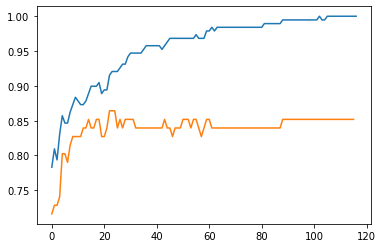

In [649]:
plt.plot(train_acc)
plt.plot(test_acc)

In [ ]:

pred = gsgp.predict(X_train)
print(classification_report(y_train,pred,digits=3))
pred = gsgp.predict(X_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        65
         1.0      1.000     1.000     1.000        80

    accuracy                          1.000       145
   macro avg      1.000     1.000     1.000       145
weighted avg      1.000     1.000     1.000       145

              precision    recall  f1-score   support

         0.0      0.867     0.812     0.839        32
         1.0      0.818     0.871     0.844        31

    accuracy                          0.841        63
   macro avg      0.842     0.842     0.841        63
weighted avg      0.843     0.841     0.841        63



# Higgs Boson

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

df = pd.read_csv('../data/HIGGS.csv',header=None)
X = df.iloc[:,1:].to_numpy()
y = df.iloc[:,0].to_numpy().astype('int')


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=500000)
Xs,ys = shuffle(X_train,y_train)

In [ ]:
X_train = Xs[:1050000]
y_train = ys[:1050000]

X_test = Xs[1050000:1210000]
y_test = ys[1050000:1210000]

In [ ]:
train_acc = []
test_acc = []

gsgp = GStackGP(X_train,y_train,1)
for i in range(1000):
    print("train start")
    gsgp.evolve()
    print("train complete")
    
    if i%10 == 0:
        pred = gsgp.predict(X_train)
        train_acc.append(roc_auc_score(y_train,pred))
        pred = gsgp.predict(X_test)
        test_acc.append(roc_auc_score(y_test,pred))
        print("train auc:",train_acc[-1],"test auc",test_acc[-1])
        
        

train start
Loss: 271919.0944547627
train complete
train auc: 0.5258654810848914 test auc 0.5246813939060924
train start
Loss: 260271.01078482388
train complete
train start
Loss: 250622.0223460063
train complete
train start
Loss: 249377.3030609782
train complete
train start
Loss: 247674.13267773198
train complete
train start
Loss: 246092.75683943022
train complete
train start
Loss: 244864.77042022234
train complete
train start
Loss: 244109.4138296209
train complete
train start
Loss: 243205.71141343552
train complete
train start
Loss: 242986.57455942972
train complete
train start
Loss: 240457.04838524185
train complete
train auc: 0.6132988188301514 test auc 0.6120390153127323
train start
Loss: 239727.16239474286
train complete
train start
Loss: 239158.3263821821
train complete
train start
Loss: 238698.26702003824
train complete
train start
Loss: 234226.41463685918
train complete
train start
Loss: 233400.83277542077
train complete
train start
Loss: 232759.91196994
train complete
train st

In [ ]:
train_acc,test_acc

([0.5258654810848914,
  0.6132988188301514,
  0.6436750800551445,
  0.6493980630859355,
  0.6538173147351156,
  0.6565614302154482,
  0.6582152004133821,
  0.6613213626863199,
  0.6635383899160323,
  0.666353789575044,
  0.668103252695043,
  0.6701625265444092,
  0.6712143528187084,
  0.6733713747050745,
  0.6746181955322843,
  0.6752672766485888,
  0.6766407141634677,
  0.6773970382984317,
  0.6779983184430831,
  0.6790438206285722,
  0.6801295273961986,
  0.6814559134172302,
  0.6821680827768668,
  0.6826158873088717,
  0.6833402715090398,
  0.6840135841631556,
  0.6850787003093606,
  0.6858402956774915,
  0.68620554784639,
  0.6870865464354777,
  0.6873719000281152,
  0.6887273207264919,
  0.6894809947705653,
  0.6904194369508995,
  0.6906725440629418,
  0.6909134399393745,
  0.691144665303587,
  0.6920069471387315,
  0.6926548970014472,
  0.6932927787363518,
  0.69436308464085,
  0.6945680994562209,
  0.695180881395156,
  0.695675791622282,
  0.6959153969002998,
  0.696364392604063